<a href="https://colab.research.google.com/github/nafisenik/DataMinig_pySpark/blob/main/pySpark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Q1

In [1]:
! pip install -q pyspark

In [2]:
! apt-get install openjdk-8-jdk-headless -qq > /dev/null
! wget -q https://dlcdn.apache.org/spark/spark-3.2.1/spark-3.2.1-bin-hadoop3.2.tgz
! tar xf spark-3.2.1-bin-hadoop3.2.tgz

In [3]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.2.1-bin-hadoop3.2"

In [4]:
! pip install -q findspark


In [5]:
import findspark
findspark.init()
findspark.find()

'/content/spark-3.2.1-bin-hadoop3.2'

In [6]:
import pyspark as py
print(py.__version__)

3.2.1


### Import Libraries

In [7]:
import random
import statistics
import time
import numpy as np
from operator import add
import matplotlib.pyplot as plt
import math
from pyspark.sql import SparkSession
import pandas as pd
import pyspark.sql.functions as F
import re
from hazm import *
from pyspark.sql.types import StringType
from pyspark.sql.functions import udf
from pyspark.sql.functions import col
from hazm import sent_tokenize, word_tokenize
from hazm import stopwords_list
from hazm import Stemmer, Lemmatizer

### Q2---> (1)

In [8]:
def MC_pi_estimator(iteration):
  circle_point = 0
  total_point = 0
  p_list =[]
  hit = 0
  start_time = time.time()
  for i in range(iteration):
    x, y = random.uniform(-1, 1), random.uniform(-1, 1)   
    if x**2 + y**2 < 1:
      circle_point += 1
    total_point += 1
    pi_num = 4.0 * circle_point / total_point
    p_list.append(pi_num)
  end = time.time()
  t = end - start_time
  return p_list, t, pi_num

### Calculate Mean and Variance

In [9]:
ITERATION = 1000000
pi_list ,time_ex, pi_est = MC_pi_estimator(ITERATION)
pi_mean = statistics.mean(pi_list)
pi_variance = statistics.variance(pi_list)
print(f'Mean of P estimate: {pi_mean}')
print(f'Variance of P estimate: {pi_variance}')
print(f'Time of P estimate: {time_ex}')

Mean of P estimate: 3.1391584646628123
Variance of P estimate: 3.528959538438914e-05
Time of P estimate: 1.2112691402435303


### Q2 ----> (3)-(4)-(5)

In [10]:
def is_inside(p):
  x, y = random.uniform(-1, 1), random.uniform(-1, 1)
  return x**2 + y**2 < 1 

### Compare Time and Pi estimate of 2 methods

--------Mont Carlo Pi Estimator Without PySparl--------
Number of Itration: 100
Pi = : 3.0
Time of computation: 0.00016641616821289062 seconds
--------Mont Carlo Pi Estimator with PySpark--------
Number of Itration: 100
Pi = : 3.12
Time of computation: 5.122607946395874 seconds
--------Mont Carlo Pi Estimator Without PySparl--------
Number of Itration: 1000
Pi = : 3.112
Time of computation: 0.0021016597747802734 seconds
--------Mont Carlo Pi Estimator with PySpark--------
Number of Itration: 1000
Pi = : 3.12
Time of computation: 1.933089256286621 seconds
--------Mont Carlo Pi Estimator Without PySparl--------
Number of Itration: 10000
Pi = : 3.1644
Time of computation: 0.03693532943725586 seconds
--------Mont Carlo Pi Estimator with PySpark--------
Number of Itration: 10000
Pi = : 3.1292
Time of computation: 1.614698886871338 seconds
--------Mont Carlo Pi Estimator Without PySparl--------
Number of Itration: 100000
Pi = : 3.14388
Time of computation: 0.5429351329803467 seconds
--------

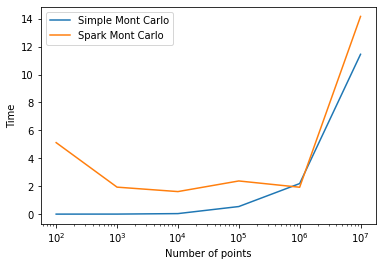

In [11]:
def MC_pi_spark(iteration):
  spark = SparkSession.builder.appName('Pi').getOrCreate()
  sc = spark.sparkContext
  start_time = time.time()
  hit = sc.parallelize(range(0, iteration), 2) \
      .map(is_inside).reduce(add)
  pi = 4.0 * hit / iteration
  t = time.time() - start_time
  spark.stop()
  return pi, t

iteration_num = [100, 1000, 10000, 100000, 1000000, 10000000]

time_simple_MC = []
time_spark_MC = []

for i in iteration_num:
    
    print('--------Mont Carlo Pi Estimator Without PySparl--------')
    pi_l, t, res = MC_pi_estimator(i)
    print(f'Number of Itration: {i}')
    print(f'Pi = : {res}')
    print(f'Time of computation: {t} seconds')
    time_simple_MC.append(t)
    
    print('--------Mont Carlo Pi Estimator with PySpark--------')   
    res, t = MC_pi_spark(i)
    print(f'Number of Itration: {i}')
    print(f'Pi = : {res}')
    print(f'Time of computation: {t} seconds')
    time_spark_MC.append(t)   
plt.figure(1)
plt.plot(iteration_num, time_simple_MC, label="Simple Mont Carlo")
plt.plot(iteration_num, time_spark_MC, label="Spark Mont Carlo")

plt.xscale("log")
plt.xlabel("Number of points")
plt.ylabel("Time")
plt.legend()
plt.show()

In [12]:
# First Method
from pyspark.sql import SparkSession

spark = SparkSession.builder\
        .master("local")\
        .appName("Colab")\
        .getOrCreate()

sc = spark.sparkContext

In [13]:
spark.version


'3.2.1'

In [14]:
! wget -q https://raw.githubusercontent.com/SajjadMb/PySpark-walkthrough/main/data/digikala_comments.csv

In [15]:
df = spark.read.option("header", True).option("multiline",True).csv("digikala_comments.csv")
df.show()


+----------+--------------------+--------+-------+-----+--------+-------------------+---------------+--------------------+--------------------+--------------------+--------------------+
|product_id|       product_title|title_en|user_id|likes|dislikes|verification_status|      recommend|               title|             comment|          advantages|       disadvantages|
+----------+--------------------+--------+-------+-----+--------+-------------------+---------------+--------------------+--------------------+--------------------+--------------------+
|      3692|ماوس بی‌سیم لاجیت...|      IT| 989472|    0|       0|           verified|             \N|                null|واقعا عالیه. من ک...|                null|                null|
|     90213|شارژر همراه شیاوم...|      AC|3862150|    4|       1|           verified|    recommended|        واقعاً عالیه|سلام، قبل اینکه ن...|  "[""عمر طولانی\r""|""افت بسیار کم می...|
|     59473|یدک پولیشر میکروف...|      HW| 626843|    1|       0|     

In [16]:
!pip install hazm

In [17]:
def convert_num(text):
  persian = ['۰', '۱', '۲', '۳', '۴', '۵', '۶', '۷', '۸', '۹']
  convertedPersianNums = text.replace('۰','0').replace('۱','1').replace('۲','2').replace('۳','3').replace('۴','4')\
  .replace('۵','5').replace('۶','6').replace('۷','7').replace('۸','8').replace('۹','9')
  return convertedPersianNums


In [18]:
stopwords = stopwords_list()+['ها','های','یه','ک','ام','ای','اگه','تر','اس','اینو','ازش','واسه','ی','هاش','برا','تره','اونم','چی','ترین','جی','داره','هست']
def remove_stop_words(text):
  text = re.sub('[^آ-ی]', ' ', text)
  tokenized_text = word_tokenize(text)
  #print(tokenized_text)
  all_tokens = [t for t in tokenized_text if t not in stopwords]
  #print(all_tokens)
  text = " ".join(all_tokens)
  return text

In [19]:
x = remove_stop_words('من از شهر به روستا رفتم و در راه علی را دیدم')
print(stopwords)

['و', 'در', 'به', 'از', 'که', 'این', 'را', 'با', 'است', 'برای', 'آن', 'یک', 'خود', 'تا', 'کرد', 'بر', 'هم', 'نیز', 'گفت', 'می\u200cشود', 'وی', 'شد', 'دارد', 'ما', 'اما', 'یا', 'شده', 'باید', 'هر', 'آنها', 'بود', 'او', 'دیگر', 'دو', 'مورد', 'می\u200cکند', 'شود', 'کند', 'وجود', 'بین', 'پیش', 'شده_است', 'پس', 'نظر', 'اگر', 'همه', 'یکی', 'حال', 'هستند', 'من', 'کنند', 'نیست', 'باشد', 'چه', 'بی', 'می', 'بخش', 'می\u200cکنند', 'همین', 'افزود', 'هایی', 'دارند', 'راه', 'همچنین', 'روی', 'داد', 'بیشتر', 'بسیار', 'سه', 'داشت', 'چند', 'سوی', 'تنها', 'هیچ', 'میان', 'اینکه', 'شدن', 'بعد', 'جدید', 'ولی', 'حتی', 'کردن', 'برخی', 'کردند', 'می\u200cدهد', 'اول', 'نه', 'کرده_است', 'نسبت', 'بیش', 'شما', 'چنین', 'طور', 'افراد', 'تمام', 'درباره', 'بار', 'بسیاری', 'می\u200cتواند', 'کرده', 'چون', 'ندارد', 'دوم', 'بزرگ', 'طی', 'حدود', 'همان', 'بدون', 'البته', 'آنان', 'می\u200cگوید', 'دیگری', 'خواهد_شد', 'کنیم', 'قابل', 'یعنی', 'رشد', 'می\u200cتوان', 'وارد', 'کل', 'ویژه', 'قبل', 'براساس', 'نیاز', 'گذاری', 'هنوز', '

In [20]:
#https://github.com/optimopium/PySpark-walkthrough/blob/main/Spark_Tutorial.ipynb
def clean_normalized(text):
  normalizer = Normalizer()
  try:
    #normalize
    cleaned_text = text.replace('_x000D_\n',' ').splitlines() 
    cleaned_text = ' '.join(cleaned_text)
    cleaned_text = normalizer.normalize(cleaned_text)
    cleaned_text = cleaned_text.replace("،"," ").replace("\u200c"," ").replace(r"\u200"," ").replace(r"\u200b"," ")\
            .replace("."," ").replace("-"," ").replace("_"," ").replace("\n"," ").replace("\r"," ").replace("\\"," ")\
            .replace("("," ").replace(")"," ").replace("["," ").replace("!"," ").replace("]"," ")\
            .replace("r"," ").replace("\""," ")
    cleaned_text = re.sub(r"\s+.\u0648.\s+", ' ', cleaned_text)
    cleaned_text = re.sub(r'[^\w\s]', ' ', cleaned_text)

    #Remove numbers
    #cleaned_text = cleaned_text.replace('x000D',' ').splitlines() 
    #cleaned_text = ' '.join(cleaned_text)
    cleaned_text = convert_num(cleaned_text)
    cleaned_text = re.sub(r'[0-9]', ' ', cleaned_text)
    cleaned_text = re.sub(' +', ' ',cleaned_text)
    cleaned_text = remove_stop_words(cleaned_text)
    return cleaned_text
  except:
    return None

In [21]:
clean_comment = udf(lambda z: clean_normalized(z))
stop_words_deletion = udf(lambda z: remove_stop_words(z))

In [22]:
df.select('product_id', 'comment').show(truncate=False)
df_res = df.select(col("product_id"),clean_comment(col("comment")).alias("comment") ) 


+----------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [23]:
df_res.show(truncate=False)

+----------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|product_id|comment                                                                                                                                                                                                  

In [24]:
selected_df = df.select("product_id", "likes", "dislikes", "comment")
popularity = selected_df.dropna().withColumn("popularity",selected_df["likes"] - selected_df["dislikes"])
popularity.orderBy("popularity", ascending=False).select('product_id','popularity').show(10)


+----------+----------+
|product_id|popularity|
+----------+----------+
|    517207|     184.0|
|    597475|     124.0|
|    503608|     115.0|
|    701679|     114.0|
|    133901|     113.0|
|    517207|     109.0|
|    443966|     108.0|
|    226249|     102.0|
|    341816|      91.0|
|    313420|      80.0|
+----------+----------+
only showing top 10 rows



In [25]:
df_word_count = df_res.withColumn('wordCount', F.size(F.split(F.col('comment'), ' ')))
df_word_count.select('product_id','wordCount').show(100)

+----------+---------+
|product_id|wordCount|
+----------+---------+
|      3692|        3|
|     90213|       93|
|     59473|       30|
|    120499|      129|
|     67200|       38|
|    133722|      127|
|    148509|       20|
|     56871|        9|
|     49738|       22|
|    161548|        1|
|      5107|       41|
|    156041|       10|
|    134367|       44|
|    114006|       15|
|    151402|       46|
|    146879|       12|
|     81254|       10|
|     26368|        4|
|     90894|       28|
|     21340|        4|
|    144139|       42|
|    138040|       36|
|    105719|       19|
|    147165|       24|
|    116387|       24|
|     73064|       42|
|    110040|       45|
|    139131|       27|
|     80854|        3|
|    163519|        6|
|    102068|      224|
|    129988|       18|
|    130386|       47|
|    160008|       15|
|     93850|       65|
|    154624|       32|
|    106471|        2|
|    112714|       29|
|    104427|       32|
|    133709|       38|
|     55495

In [26]:
df_final = df_res.select(col("product_id"),stop_words_deletion(col("comment")).alias("comment") ) 
df_final.show(truncate=False)

+----------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|product_id|comment                                                                                                                                                                                                  

In [27]:
df_res.withColumn('word', F.explode(F.split(F.col('comment'), ' ')))\
    .groupBy('word')\
    .count()\
    .sort('count', ascending=False)\
    .show(100)

+-------+-----+
|   word|count|
+-------+-----+
|استفاده| 1783|
|  کیفیت| 1594|
|   میشه| 1389|
|  خریدم| 1300|
|   گوشی| 1174|
|   خوبه| 1140|
|  عالیه| 1140|
|  واقعا| 1076|
|   اصلا|  981|
|  میکنم|  933|
|  نداره|  884|
|   قیمت|  884|
|  میکنه|  883|
|   خرید|  858|
|    کار|  837|
|   دیجی|  808|
|   راضی|  801|
|   شارژ|  792|
|پیشنهاد|  769|
|   کالا|  707|
|   باشه|  642|
|   دیگه|  635|
|  محصول|  629|
|   سلام|  615|
|  قیمتش|  565|
| دستگاه|  492|
|  گرفتم|  491|
|   دارم|  489|
|   ساعت|  464|
|   حتما|  464|
| دوستان|  455|
|    ماه|  454|
|    مدل|  453|
|    رنگ|  444|
|   الان|  440|
|  راضیم|  428|
|   ارزش|  413|
|    جنس|  408|
|   میده|  381|
|  نمیشه|  381|
|   بازی|  378|
|    کنه|  374|
|   هستش|  367|
|    سال|  366|
|   هستم|  352|
|    دست|  346|
|   مشکل|  330|
|  بخرید|  323|
|  خوبیه|  323|
|   دستم|  322|
|   راحت|  315|
|    نمی|  313|
|    بشه|  312|
|    بگم|  303|
|   توجه|  293|
| دوربین|  291|
|   شگفت|  290|
| العاده|  283|
|   صفحه|  280|
|   صدای

In [35]:
def tokenize(input_text):
  try:
    lemmatizer = Lemmatizer()
    token_text = word_tokenize(input_text)
    token_text_final = [lemmatizer.lemmatize(t) for t in token_text]
    token_text_final = list(set(token_text_final))
    return ','.join(token_text_final)
  except:
    return None

In [34]:
tokenize('سلام من خوبم تو خوبی؟')

<class 'list'>


'سلام,من,خوب,تو,خوبی,؟'

In [36]:
comment_tokenization = udf(lambda z: tokenize(z))
df_tokenize = df_res.select(col("product_id"),comment_tokenization(col("comment")).alias("comment") ) 
df_tokenize.show(20)

+----------+--------------------+
|product_id|             comment|
+----------+--------------------+
|      3692|   راضیم,واقعا,عالیه|
|     90213|هوشمند,همزمان,همس...|
|     59473|فلز,ساده,گیره,بلا...|
|    120499|هدفون,متداول,فلز,...|
|     67200|سریع,ضخامت,راحت,آ...|
|    133722|قبل,تحقیق,داشت#دا...|
|    148509|مقایسه,بالاتره,شک...|
|     56871|بو,خوشبو,چقدر,میش...|
|     49738|دکمه,ماشین,حالت,ب...|
|    161548|            بودممنون|
|      5107|عنوان,آپ,دسکتاپ,ا...|
|    156041|ماشین,کارکرد,معمو...|
|    134367|کالا,ازدست,لطفا,و...|
|    114006|راضی,واقعا,کالا,پ...|
|    151402|برآورده,غیرقابل,ا...|
|    146879|گرم,کن,یکم,قدرت,ز...|
|     81254|برد#بر,راضی,ازین,...|
|     26368| راضی,دارمش,الان,سال|
|     90894|پاره,داشت#دار,میر...|
|     21340|راضی,مناسبه,قیمت,...|
+----------+--------------------+
only showing top 20 rows



In [37]:
from pyspark.sql.functions import split, col
df2 = df_tokenize.select(split(col("comment"),",").alias("commentArray")) \
    .drop("comment")
df2.printSchema()
df2.show()

root
 |-- commentArray: array (nullable = true)
 |    |-- element: string (containsNull = true)

+--------------------+
|        commentArray|
+--------------------+
|[راضیم, واقعا, عا...|
|[هوشمند, همزمان, ...|
|[فلز, ساده, گیره,...|
|[هدفون, متداول, ف...|
|[سریع, ضخامت, راح...|
|[قبل, تحقیق, داشت...|
|[مقایسه, بالاتره,...|
|[بو, خوشبو, چقدر,...|
|[دکمه, ماشین, حال...|
|          [بودممنون]|
|[عنوان, آپ, دسکتا...|
|[ماشین, کارکرد, م...|
|[کالا, ازدست, لطف...|
|[راضی, واقعا, کال...|
|[برآورده, غیرقابل...|
|[گرم, کن, یکم, قد...|
|[برد#بر, راضی, از...|
|[راضی, دارمش, الا...|
|[پاره, داشت#دار, ...|
|[راضی, مناسبه, قی...|
+--------------------+
only showing top 20 rows



In [30]:
df_tokenize.printSchema

<bound method DataFrame.printSchema of DataFrame[product_id: string, comment: string]>

In [39]:
'''
from pyspark.ml.fpm import FPGrowth

df_f = spark.createDataFrame([
    (0, [1, 2, 5]),
    (1, [1, 2, 3, 5]),
    (2, [1, 2])
], ["id", "items"])

fpGrowth = FPGrowth(itemsCol="commentArray", minSupport=0.5, minConfidence=0.6)
model = fpGrowth.fit(df2)

# Display frequent itemsets.
model.freqItemsets.show()

# Display generated association rules.
model.associationRules.show()

# transform examines the input items against all the association rules and summarize the
# consequents as prediction
model.transform(df_tokenize).show()
'''

'\nfrom pyspark.ml.fpm import FPGrowth\n\ndf_f = spark.createDataFrame([\n    (0, [1, 2, 5]),\n    (1, [1, 2, 3, 5]),\n    (2, [1, 2])\n], ["id", "items"])\n\nfpGrowth = FPGrowth(itemsCol="commentArray", minSupport=0.5, minConfidence=0.6)\nmodel = fpGrowth.fit(df2)\n\n# Display frequent itemsets.\nmodel.freqItemsets.show()\n\n# Display generated association rules.\nmodel.associationRules.show()\n\n# transform examines the input items against all the association rules and summarize the\n# consequents as prediction\nmodel.transform(df_tokenize).show()\n'

### Q5

In [52]:

from collections import defaultdict
class Graph:

  def __init__(self):
    self.graph = defaultdict(list)

  def add_edge(self,u,v):
    self.graph[u].append(v)

  def BFS(self, n):
    visited_node =  [0 for i in range(len(self.graph))]
    queue = []
    queue.append(n)
    visited_node[n] = 1
    while queue:
      node = queue.pop(0)
      print (node, end = "--->")
      for n in self.graph[node]:
        if visited_node[n] == 0:
          queue.append(n)
          visited_node[n] = 1

Following is Breadth First Traversal (starting from vertex 2)
2--->0--->3--->1--->

In [42]:
g = Graph()
g.add_edge(0, 1)
g.add_edge(0, 2)
g.add_edge(1, 2)
g.add_edge(2, 0)
g.add_edge(2, 3)
g.add_edge(3, 3)

print ("Following is Breadth First Traversal"
				" (starting from vertex 2)")
g.BFS(2)


In [43]:
visited

[False, False, False, False]

In [ ]:
df_tokenize.show(truncate=False)

### Q4

In [ ]:

pdf = pd.read_csv("https://raw.githubusercontent.com/SajjadMb/PySpark-walkthrough/main/data/digikala_comments.csv")
selected = pdf.comment
df = pd.DataFrame(selected)

df

In [ ]:
from pyspark.sql.types import *
from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)


# Auxiliar functions
def equivalent_type(f):
    if f == 'datetime64[ns]': return TimestampType()
    elif f == 'int64': return LongType()
    elif f == 'int32': return IntegerType()
    elif f == 'float64': return FloatType()
    else: return StringType()

def define_structure(string, format_type):
    try: typo = equivalent_type(format_type)
    except: typo = StringType()
    return StructField(string, typo)

# Given pandas dataframe, it will return a spark's dataframe.
def pandas_to_spark(pandas_df):
    columns = list(pandas_df.columns)
    types = list(pandas_df.dtypes)
    struct_list = []
    for column, typo in zip(columns, types): 
      struct_list.append(define_structure(column, typo))
    p_schema = StructType(struct_list)
    return sqlContext.createDataFrame(pandas_df, p_schema)

In [ ]:
res=pandas_to_spark(pdf)

In [ ]:
res.show()



In [ ]:
res.printSchema

In [ ]:
comment = pandas_to_spark(df)
comment.show()
print(comment.collect()[1])

In [ ]:
from hazm import *
from pyspark.sql.functions import udf
from pyspark.sql.functions import col

normalizer = Normalizer()
def normalize(text):
  normalized = normalizer.normalize(text)
  return normalized
s = ' اگر هر کابل دیگه ای وصل کنیدی'
a = normalize(s)
print(s)
print(a)

convertUDF = udf(lambda z: normalize(z)) 

normal_res = res.select(col("product_id"), \
    convertUDF(col("comment")).alias("comment") ) \
   .show(truncate=False)


In [ ]:
print(normal_res.collect()[5])
print(comment.collect()[5])